In [1]:
#Classificação de imagens
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.preprocessing.image import load_img

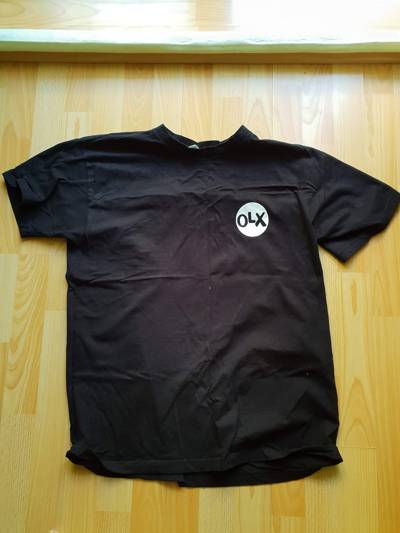

In [3]:
#path = 'd:\dataset\clothing-dataset-small\train\t-shirt'
path = 'd:/dataset/clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
load_img(fullname)

#df = pd.read_csv(r'd:\dataset\cardataset\data.csv')

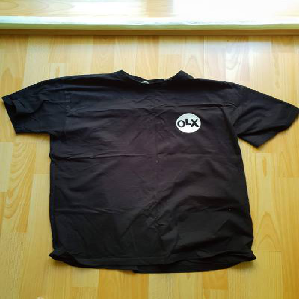

In [4]:
#Formatar a imagem no padrão da rede neural 
# Uso de rede neural convolucional para extrair padrões de uma imagem
load_img(fullname, target_size=(299,299))

Pré treinando a rede neural

In [5]:
#importa o modelo Xception que possui 71 camadas
from tensorflow.keras.applications.xception import Xception
#prepara a imagem para ser usada
from tensorflow.keras.applications.xception import preprocess_input
#decodifica a predição do modelo
from tensorflow.keras.applications.xception import decode_predictions

In [6]:
model = Xception(
    weights = 'imagenet', #modelo pre treinado de ImageNet
    input_shape=(299, 299, 3) #height, width, channel (rgb)
)
#Não está usando base_model.trainable = False, então roda o treinamento default

In [7]:
#carregar a imagem
img =load_img(fullname, target_size=(299,299))
#Converter o objeto img (Image) num array NumPY
x = np.array(img)
x.shape #mostra o shape do array

(299, 299, 3)

In [8]:
#Para utilizar mais imagens (ex.: 10), (10, 299,299,3)
X = np.array([x]) #x=1a imagem, y=2a imagem, z= 3a imagem 
X.shape

(1, 299, 299, 3)

In [9]:
#Preparar a entrada do modelo
X = preprocess_input(X) #converte inteiros entre 0 e 255 em números entre -1 e 1

In [10]:
# Usar o modelo para predizer
pred = model.predict(X)
pred.shape

(1, 1000)

In [11]:
pred[0, :10]

array([0.0003238 , 0.00015736, 0.00021406, 0.00015296, 0.00024657,
       0.00030446, 0.00032349, 0.00014726, 0.00020487, 0.00014866],
      dtype=float32)

In [12]:
#Probabilidade de imagem pertencer em uma das 1000 classes
#Decodificar a função para ver o nome das classes
decode_predictions(pred)

[[('n03595614', 'jersey', 0.67924464),
  ('n02916936', 'bulletproof_vest', 0.039600365),
  ('n04370456', 'sweatshirt', 0.035299625),
  ('n03710637', 'maillot', 0.010884146),
  ('n04525038', 'velvet', 0.0018057626)]]

Não é o que queremos, vamos treinar nosso próprio modelo. 

In [13]:
#Ao invés de carregar cada imagem uma por uma, nós usamos um gerador. 
#Keras irá usar ele para carregar as imagens e pré-processar eles. 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#ImageDataGenerator carrega imagens do disco em pequenos lotes
#Dataset de treinamento
#Vamos usar imagens menores que são mais rápidas
image_size = (150,150)
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
train_ds = train_gen.flow_from_directory('d:/dataset/clothing-dataset-small/train',
        seed=1,
        target_size=image_size,
        batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [14]:
#Dataset de validação 
validation_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
val_ds = validation_gen.flow_from_directory(
    'd:/dataset/clothing-dataset-small/validation',
    seed=1,
    target_size=image_size, 
    batch_size=batch_size, 
)

Found 341 images belonging to 10 classes.


Criação do modelo

Incluimos somente a parte convolucional do modelo pre treinado e depois adicionamos a nossa própria camada densa


In [15]:
base_model = Xception(
    weights='imagenet', #usa o modelo pré-treinado em ImageNet
    input_shape = (150,150,3),
    include_top=False, #matém somente as camadas convolucionais
)
base_model.trainable = False # Não treinamos o modelo base, senão destruiria os filtros

In [16]:
#Construção do modelo de classificação
inputs = keras.Input(shape=(150,150,3)) #Imagens de entrada devem ser 150x150 com 3 canais
base = base_model(inputs, training=False)  #usa o modelo base para obter as características de alto nível
#extrai a representação do vetor, converte a saída do modelo base para um vetor
#base é usado como entrada para a próxima camada
#Pooling converte a camada convolucional (array 3D) em um vetor (1 D)
vector = keras.layers.GlobalAveragePooling2D()(base)
#adiciona vector a próxima camada (densa)
outputs = keras.layers.Dense(10)(vector)
#Cria o modelo com a entrada e saída
model = keras.Model(inputs, outputs)

Treinando o modelo (a partir do modelo base)

In [17]:
#Utilização do algoritmo de otimização Adam: ajusta os pesos da rede
learning_rate = 0.01 # velocidade com que a rede aprende
optimizer = keras.optimizers.Adam(learning_rate)

In [18]:
#parâmetro para verificar se a rede está evoluindo bem 
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
#from_logits = saída da rede em formato logits e não probabilidades

In [19]:
#outputs = keras.layers.Dense(10, activation='softmax')(vector)
#loss = keras.losses.CategoricalCrossentropy()

In [20]:
#colocar o optimizer e o loss juntos 
model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=['accuracy'] #métrica para monitorar durante o treinamento
    #accuracy: percentagem de imagens com predições corretas. 
)

In [21]:
#treinamento 
history=model.fit(train_ds, epochs=10, validation_data=val_ds)
# 1 epoch = 1 interação sobre o dataset inteiro


Epoch 1/10
96/96 [==============================] - 104s 1s/step - loss: 1.2741 - accuracy: 0.6763 - val_loss: 0.9019 - val_accuracy: 0.7625
Epoch 2/10
96/96 [==============================] - 98s 1s/step - loss: 0.5553 - accuracy: 0.8233 - val_loss: 0.7867 - val_accuracy: 0.7859
Epoch 3/10
96/96 [==============================] - 96s 998ms/step - loss: 0.3526 - accuracy: 0.8778 - val_loss: 0.7750 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 90s 934ms/step - loss: 0.2557 - accuracy: 0.9074 - val_loss: 0.8725 - val_accuracy: 0.7918
Epoch 5/10
96/96 [==============================] - 98s 1s/step - loss: 0.2049 - accuracy: 0.9374 - val_loss: 0.9300 - val_accuracy: 0.8006
Epoch 6/10
96/96 [==============================] - 98s 1s/step - loss: 0.1489 - accuracy: 0.9482 - val_loss: 0.9236 - val_accuracy: 0.8035
Epoch 7/10
96/96 [==============================] - 103s 1s/step - loss: 0.1160 - accuracy: 0.9566 - val_loss: 1.0314 - val_accuracy: 0.7859
Epoch 8/10
9

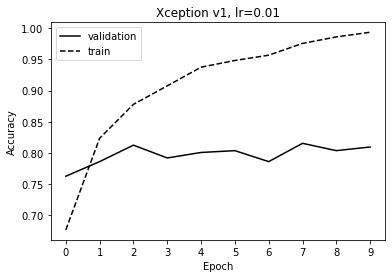

In [22]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


plt.savefig('xception_v1_0_01.svg')

plt.show()

0.01 não é necessariamente a melhor taxa de aprendizado. Experimentar com 0.001 e 0.0001. 

In [23]:
#criar uma função para definir os modelos 
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150,150,3),
        include_top=False
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate), 
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy'],
    )
    return model 

In [24]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 97s 989ms/step - loss: 1.0759 - accuracy: 0.6362 - val_loss: 0.7313 - val_accuracy: 0.7449
Epoch 2/10
96/96 [==============================] - 103s 1s/step - loss: 0.6248 - accuracy: 0.7832 - val_loss: 0.6158 - val_accuracy: 0.7947
Epoch 3/10
96/96 [==============================] - 101s 1s/step - loss: 0.5018 - accuracy: 0.8331 - val_loss: 0.5765 - val_accuracy: 0.8152
Epoch 4/10
96/96 [==============================] - 107s 1s/step - loss: 0.4267 - accuracy: 0.8647 - val_loss: 0.5493 - val_accuracy: 0.8328
Epoch 5/10
96/96 [==============================] - 105s 1s/step - loss: 0.3687 - accuracy: 0.8859 - val_loss: 0.5694 - val_accuracy: 0.7977
Epoch 6/10
96/96 [==============================] - 103s 1s/step - loss: 0.3221 - accuracy: 0.9065 - val_loss: 0.5204 - val_accuracy: 0.8328
Epoch 7/10
96/96 [==============================] - 97s 1s/step - loss: 0.2879 - accuracy: 0.9241 - val_loss: 0.5202 - val_accuracy: 0.8182
Epoch 8/10
9

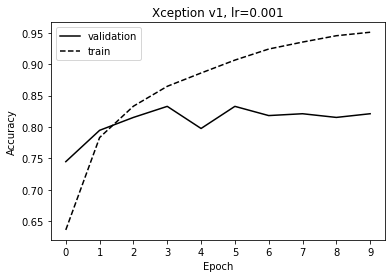

In [25]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_001.svg')

plt.show()

In [26]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 93s 957ms/step - loss: 2.1111 - accuracy: 0.2855 - val_loss: 1.7289 - val_accuracy: 0.4868
Epoch 2/10
96/96 [==============================] - 100s 1s/step - loss: 1.4721 - accuracy: 0.5349 - val_loss: 1.3093 - val_accuracy: 0.5894
Epoch 3/10
96/96 [==============================] - 107s 1s/step - loss: 1.1870 - accuracy: 0.6193 - val_loss: 1.1017 - val_accuracy: 0.6364
Epoch 4/10
96/96 [==============================] - 106s 1s/step - loss: 1.0315 - accuracy: 0.6760 - val_loss: 0.9803 - val_accuracy: 0.6745
Epoch 5/10
96/96 [==============================] - 103s 1s/step - loss: 0.9305 - accuracy: 0.6988 - val_loss: 0.8968 - val_accuracy: 0.7067
Epoch 6/10
96/96 [==============================] - 98s 1s/step - loss: 0.8586 - accuracy: 0.7177 - val_loss: 0.8399 - val_accuracy: 0.7537
Epoch 7/10
96/96 [==============================] - 97s 1s/step - loss: 0.8031 - accuracy: 0.7327 - val_loss: 0.8009 - val_accuracy: 0.7507
Epoch 8/10
96

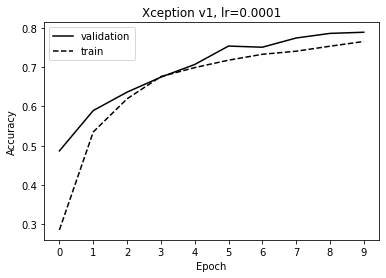

In [27]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_0001.svg')

plt.show()

In [28]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

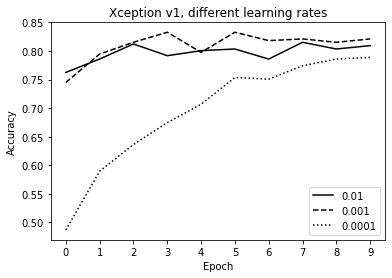

In [29]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('xception_v1_all_lr.svg')

plt.show()

Para salvar o modelo (monitora e salva e melhor epoch), utilizar um callback (executa quando cada epoch termina)

In [30]:
model = make_model(learning_rate=0.001)

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]
#especifica a lista de callback a ser executada
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - 104s 1s/step - loss: 1.0708 - accuracy: 0.6411 - val_loss: 0.7284 - val_accuracy: 0.7507
Epoch 2/10
96/96 [==============================] - 101s 1s/step - loss: 0.6306 - accuracy: 0.7829 - val_loss: 0.6341 - val_accuracy: 0.8035
Epoch 3/10
96/96 [==============================] - 95s 988ms/step - loss: 0.5030 - accuracy: 0.8308 - val_loss: 0.6065 - val_accuracy: 0.8065
Epoch 4/10
96/96 [==============================] - 100s 1s/step - loss: 0.4285 - accuracy: 0.8634 - val_loss: 0.5607 - val_accuracy: 0.8211
Epoch 5/10
96/96 [==============================] - 98s 1s/step - loss: 0.3686 - accuracy: 0.8853 - val_loss: 0.5379 - val_accuracy: 0.8299
Epoch 6/10
96/96 [==============================] - 92s 961ms/step - loss: 0.3272 - accuracy: 0.9009 - val_loss: 0.5419 - val_accuracy: 0.8240
Epoch 7/10
96/96 [==============================] - 101s 1s/step - loss: 0.2909 - accuracy: 0.9198 - val_loss: 0.5395 - val_accuracy: 0.8270
Epoch 8/10

Adicionar mais uma camada

In [33]:


def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [34]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 87s 886ms/step - loss: 1.0221 - accuracy: 0.6571 - val_loss: 0.6738 - val_accuracy: 0.7859
Epoch 2/30
96/96 [==============================] - 94s 976ms/step - loss: 0.5254 - accuracy: 0.8250 - val_loss: 0.6055 - val_accuracy: 0.8035
Epoch 3/30
96/96 [==============================] - 90s 941ms/step - loss: 0.3868 - accuracy: 0.8745 - val_loss: 0.5811 - val_accuracy: 0.8035
Epoch 4/30
96/96 [==============================] - 92s 953ms/step - loss: 0.2792 - accuracy: 0.9091 - val_loss: 0.5228 - val_accuracy: 0.8182
Epoch 5/30
96/96 [==============================] - 97s 1s/step - loss: 0.1959 - accuracy: 0.9452 - val_loss: 0.5484 - val_accuracy: 0.8182
Epoch 6/30
96/96 [==============================] - 88s 919ms/step - loss: 0.1417 - accuracy: 0.9674 - val_loss: 0.5622 - val_accuracy: 0.8182
Epoch 7/30
96/96 [==============================] - 100s 1s/step - loss: 0.1053 - accuracy: 0.9769 - val_loss: 0.5547 - val_accuracy: 0.8240
Epoc

In [35]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 99s 1s/step - loss: 1.0681 - accuracy: 0.6346 - val_loss: 0.7219 - val_accuracy: 0.7537
Epoch 2/30
96/96 [==============================] - 102s 1s/step - loss: 0.6288 - accuracy: 0.7878 - val_loss: 0.5948 - val_accuracy: 0.7977
Epoch 3/30
96/96 [==============================] - 102s 1s/step - loss: 0.4568 - accuracy: 0.8449 - val_loss: 0.5560 - val_accuracy: 0.8211
Epoch 4/30
96/96 [==============================] - 103s 1s/step - loss: 0.3577 - accuracy: 0.8804 - val_loss: 0.5463 - val_accuracy: 0.8240
Epoch 5/30
96/96 [==============================] - 101s 1s/step - loss: 0.2695 - accuracy: 0.9058 - val_loss: 0.5771 - val_accuracy: 0.8211
Epoch 6/30
96/96 [==============================] - 101s 1s/step - loss: 0.2135 - accuracy: 0.9342 - val_loss: 0.5255 - val_accuracy: 0.8387
Epoch 7/30
96/96 [==============================] - 101s 1s/step - loss: 0.1839 - accuracy: 0.9423 - val_loss: 0.5605 - val_accuracy: 0.8328
Epoch 8/30
96/

In [36]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 125s 1s/step - loss: 1.2730 - accuracy: 0.5759 - val_loss: 0.7368 - val_accuracy: 0.7830
Epoch 2/30
96/96 [==============================] - 118s 1s/step - loss: 0.8147 - accuracy: 0.7259 - val_loss: 0.6219 - val_accuracy: 0.8094
Epoch 3/30
96/96 [==============================] - 105s 1s/step - loss: 0.6706 - accuracy: 0.7735 - val_loss: 0.5851 - val_accuracy: 0.8211
Epoch 4/30
96/96 [==============================] - 100s 1s/step - loss: 0.5964 - accuracy: 0.7917 - val_loss: 0.5783 - val_accuracy: 0.8182
Epoch 5/30
96/96 [==============================] - 100s 1s/step - loss: 0.4966 - accuracy: 0.8328 - val_loss: 0.5932 - val_accuracy: 0.8035
Epoch 6/30
96/96 [==============================] - 95s 992ms/step - loss: 0.4580 - accuracy: 0.8426 - val_loss: 0.5471 - val_accuracy: 0.8211
Epoch 7/30
96/96 [==============================] - 92s 956ms/step - loss: 0.3910 - accuracy: 0.8677 - val_loss: 0.5570 - val_accuracy: 0.8240
Epoch 8/3

In [37]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 99s 1s/step - loss: 1.7939 - accuracy: 0.3999 - val_loss: 1.1594 - val_accuracy: 0.6628
Epoch 2/30
96/96 [==============================] - 90s 941ms/step - loss: 1.3764 - accuracy: 0.5257 - val_loss: 0.9762 - val_accuracy: 0.7126
Epoch 3/30
96/96 [==============================] - 98s 1s/step - loss: 1.2795 - accuracy: 0.5590 - val_loss: 0.8776 - val_accuracy: 0.7185
Epoch 4/30
96/96 [==============================] - 98s 1s/step - loss: 1.1932 - accuracy: 0.5675 - val_loss: 0.7961 - val_accuracy: 0.7507
Epoch 5/30
96/96 [==============================] - 97s 1s/step - loss: 1.1154 - accuracy: 0.6017 - val_loss: 0.7514 - val_accuracy: 0.7713
Epoch 6/30
96/96 [==============================] - 94s 981ms/step - loss: 1.0773 - accuracy: 0.6111 - val_loss: 0.7726 - val_accuracy: 0.7595
Epoch 7/30
96/96 [==============================] - 102s 1s/step - loss: 1.0434 - accuracy: 0.6203 - val_loss: 0.7269 - val_accuracy: 0.7918
Epoch 8/30
96

In [38]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

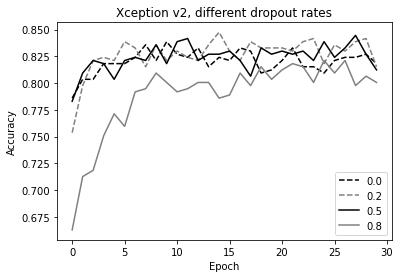

In [39]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

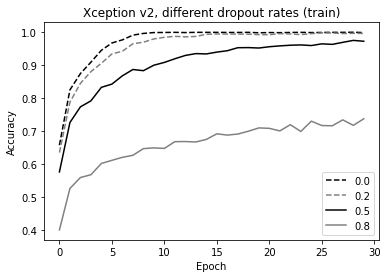

In [40]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

Data augmentation

In [41]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    'd:/dataset/clothing-dataset-small/train',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [42]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    'd:/dataset/clothing-dataset-small/train',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [43]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v3_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks)

Epoch 1/50
96/96 [==============================] - 166s 2s/step - loss: 1.1293 - accuracy: 0.6170 - val_loss: 0.6326 - val_accuracy: 0.7846
Epoch 2/50
96/96 [==============================] - 178s 2s/step - loss: 0.7285 - accuracy: 0.7477 - val_loss: 0.4845 - val_accuracy: 0.8364
Epoch 3/50
96/96 [==============================] - 183s 2s/step - loss: 0.6240 - accuracy: 0.7911 - val_loss: 0.4108 - val_accuracy: 0.8631
Epoch 4/50
96/96 [==============================] - 187s 2s/step - loss: 0.5164 - accuracy: 0.8344 - val_loss: 0.3515 - val_accuracy: 0.8807
Epoch 5/50
96/96 [==============================] - 192s 2s/step - loss: 0.4645 - accuracy: 0.8357 - val_loss: 0.3069 - val_accuracy: 0.8980
Epoch 6/50
96/96 [==============================] - 191s 2s/step - loss: 0.4287 - accuracy: 0.8449 - val_loss: 0.3116 - val_accuracy: 0.8944
Epoch 7/50
96/96 [==============================] - 185s 2s/step - loss: 0.4046 - accuracy: 0.8559 - val_loss: 0.2529 - val_accuracy: 0.9224
Epoch 8/50
96

In [44]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

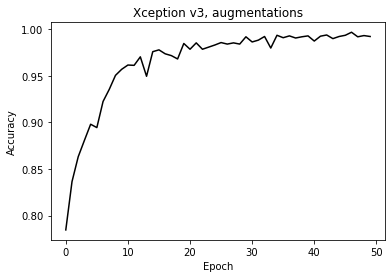

In [45]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, accuracy, color='black', linestyle='solid')


plt.title('Xception v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('xception_v3_aug.svg')

plt.show()

Larger model

In [46]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(299, 299, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [50]:
image_size = (299, 299)
batch_size = 32

In [52]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    'd:/dataset/clothing-dataset-small/train',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [53]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    'd:/dataset/clothing-dataset-small/train',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [54]:

model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v4_large_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_l = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
96/96 [==============================] - 700s 7s/step - loss: 0.8344 - accuracy: 0.7161 - val_loss: 0.4171 - val_accuracy: 0.8563
Epoch 2/20
96/96 [==============================] - 686s 7s/step - loss: 0.4645 - accuracy: 0.8439 - val_loss: 0.3117 - val_accuracy: 0.8993
Epoch 3/20
96/96 [==============================] - 688s 7s/step - loss: 0.3848 - accuracy: 0.8631 - val_loss: 0.2612 - val_accuracy: 0.9126
Epoch 4/20
96/96 [==============================] - 2449s 8s/step - loss: 0.3397 - accuracy: 0.8814 - val_loss: 0.2336 - val_accuracy: 0.9250
Epoch 5/20
96/96 [==============================] - 691s 7s/step - loss: 0.3033 - accuracy: 0.8924 - val_loss: 0.2037 - val_accuracy: 0.9319
Epoch 6/20
96/96 [==============================] - 2110s 22s/step - loss: 0.2678 - accuracy: 0.9078 - val_loss: 0.1984 - val_accuracy: 0.9267
Epoch 7/20
96/96 [==============================] - 746s 8s/step - loss: 0.2490 - accuracy: 0.9179 - val_loss: 0.1724 - val_accuracy: 0.9430
Epoch 8/20